### Import modules

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib

import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

# I.Import Of Data
1.   Limited Partners
2.   Fund Managers
3.   Commitment Records



In [45]:
#import data from google drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [46]:
#Import limited partner features
link = 'https://drive.google.com/file/d/1z7ijrsjltlwcYeeuPGkKm_RgIHr7_zJy/view?usp=sharing'


# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('lp_all.csv') 
 
lp_read = pd.read_csv('lp_all.csv',encoding = "ISO-8859-1")

In [47]:
#Import fund manager features
link = 'https://drive.google.com/file/d/1Z33GsgSjFas6go0w0Eu5_tLe8s4ZkXGc/view?usp=sharing'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fm_all.csv') 
 
fm_read = pd.read_csv('fm_all.csv',encoding = "ISO-8859-1")

In [48]:
#Import targets: commitment records
#the commitment means a limited partner ever invested in a fund manager

link = 'https://drive.google.com/file/d/1z4QdXM45mgU7zGzhX_IWXHFo0O6xOtei/view?usp=sharing'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('lp_cmmt_final.csv') 
 
cmmt = pd.read_csv('lp_cmmt_final.csv')
cmmt = cmmt.dropna()

### Emerging fund manager:
#### Here emerging funds are defined as fund managers of NA region with fund size less then 250M and at their first 3-4 funds. The filter condition could be altered here.

In [49]:
fm_match = fm_read[['fund_manager_id','fund_manager_id_orig','fund_manager','strategies','fund_size','region_if_na','fund_num','sectors']]
fm_match = fm_match[(fm_match.fund_size <= 250) & (fm_match.region_if_na ==1) & (fm_match.fund_num <= 4) & (fm_match.fund_num >=3)]
#Number of emerging funds:
len(fm_match)

530

# II. Data Cleaning

## (i)Limited Partners

In [50]:
lp_all = lp_read[['lp_id','type_num','lp_if_na','asset_amount_bucket','sector']]
lp_all

,lp_id,type_num,lp_if_na,asset_amount_bucket,sector
0,1,9,1,2,"Diversified,Healthcare,TMT"
1,2,2,0,8,"Biotech / Life Science,Clean Tech / Renewable,..."
2,3,22,0,8,"Clean Tech / Renewable,Financial Services,Heal..."
3,4,15,1,0,"Diversified,Financial Services,Industrials"
4,5,21,1,6,"Consumer Goods,Diversified,Retail,TMT"
...,...,...,...,...,...
5710,5711,3,0,0,Biotech / Life Science
5711,5712,3,0,3,TMT
5712,5713,7,0,5,Healthcare
5713,5714,3,1,3,Business Services


#### Features 

- lp_id: Newly assigned id for the model training
- lp_if_na: If limited partner in North America
- sector: The sector/industry the lp are interested
- asset_amount_bucket(asset amount in million USD)

  * 0: (-0.001, 20.6]
  * 1: (20.6, 149.975]
  * 2: (149.975, 381.06]
  * 3: (381.06, 949.175]
  * 4: (949.175, 2110.0]
  * 5: (2110.0, 4889.2]
  * 6: (4889.2, 13665.59]
  * 7: (13665.59, 47820.0]
  * 8: (47820.0, 10100000.0]
  

- type_num

    * 1: Asset Manager
    * 2: Bank / Financial Services
    * 3: Corporate
    * 4: Corporate Pension
    * 5: Corporate Subsidiary/Division
    * 6: Direct Investment
    * 7: Economic Development Agency
    * 8: Family Office
    * 9: Foundation / Endowment
    * 10: Fund of Funds Manager
    * 11: Gatekeepers
    * 12: Government Related Investment Organisation
    * 13: High-net-worth investor
    * 14: Independent Firm
    * 15: Insurance Company
    * 16: Investment Advisor
    * 17: Investment Firm
    * 18: Money Management Firm
    * 19: Other limited Partner
    * 20: Private Investment Fund
    * 21: Private Pension Fund
    * 22: Public Pension Fund
    * 23: Real Estate Investment Company
    * 24: Secondary LP
    * 25: Sovereign Wealth Fund
    * 26: Union Pension Fund
    * 27: University (Non-Foundation / Endowment)
    * 28: Wealth Management Firm
    

    




## (ii) Fund Manager

In [51]:
fm_all = fm_read[['fund_manager_id','strategies','region_if_na','fund_num','fund_size_bucket','sectors']]
fm_all

,fund_manager_id,strategies,region_if_na,fund_num,fund_size_bucket,sectors
0,1,Buyout / Corporate Private Equity,1,1,7,Diversified
1,2,Venture Capital / Growth Equity,1,9,9,"Clean Tech / Renewable,Financial Services,Fina..."
2,3,Fund of Funds / Co-Investment,1,2,6,"Diversified,Diversified"
3,4,Fund of Funds / Co-Investment,1,22,9,"Diversified,Diversified,Clean Tech / Renewable..."
4,5,Venture Capital / Growth Equity,1,2,8,"Diversified,TMT"
...,...,...,...,...,...,...
7319,7320,Asset Management,1,4,2,Unknown
7320,7321,Asset Management,1,0,0,TMT
7321,7322,Buyout / Corporate Private Equity,1,0,0,Energy / Oil & Gas
7322,7323,Buyout / Corporate Private Equity,1,2,3,TMT


### Features

- Newly assigned fund manager id for the model training
- region_if_na: If fund manager has office in North America
- strategies: The type of fund manager
- sectors: The sector/industry the fund managers are interested
- fund_size_bucket(fund size in million USD)

  * 0: (-0.001, 10.1]  
  * 1: (10.1, 28.492]   
  * 2: (28.492, 50.0] 
  * 3: (50.0, 81.652] 
  * 4: (81.652, 118.31] 
  * 5: (118.31, 172.336]
  * 6: (172.336, 250.0]
  * 7: (250.0, 559.521
  * 8: (559.521, 1685.622]
  
    




# III. Transformation function

In [52]:
from collections import Counter

def remov_duplicates(input):
    input = input.split(",")
    UniqW = Counter(input)
    s = ",".join(UniqW.keys())
    return s

In [53]:
def load_data():
   
    
    lp_all_orig = lp_all.values
    fm_all_orig = fm_all.values

    lp = lp_all.copy()
    fm = fm_all.copy()

    lp['sector'] = lp['sector'].apply(remov_duplicates)
    fm['sectors'] = fm['sectors'].apply(remov_duplicates)


    # #sector genres
    genres_set = set()
    for val in lp['sector'].str.split(','):
       genres_set.update(val)
    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}


    genres_map = {val:[genres2int[row] for row in val.split(',')] for ii,val in enumerate(set(lp['sector']))}
    for key in genres_map:
        for cnt in range(max(genres2int .values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])

    lp['sector'] =  lp['sector'].map(genres_map)

    genres_map = {val:[genres2int[row] for row in val.split(',')] for ii,val in enumerate(set(fm['sectors']))}
    for key in genres_map:
       for cnt in range(max(genres2int.values()) - len(genres_map[key])):
           genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])

    fm['sectors']= fm['sectors'].map(genres_map)

    fm_str_map = {'Buyout / Corporate Private Equity': 1, 'Venture Capital / Growth Equity': 2,'Fund of Funds / Co-Investment':3,
            'Mezzanine / Debt':4, 'Secondaries':5,'Distressed / Turnaround':6,'Other':7, 'Asset Management':8}
    fm['strategies'] = fm['strategies'].map(fm_str_map)

    lp['lp_id'] = lp['lp_id'].astype(int)
    fm['fund_manager_id'] = fm['fund_manager_id'].astype(int)
    cmmt['fund_manager_id'] = cmmt['fund_manager_id'].astype(int)
    cmmt['lp_id'] = cmmt['lp_id'].astype(int)
    cmmt['if_cmmt'] = cmmt['if_cmmt'] .astype(float)

    data = pd.merge(pd.merge(cmmt, lp), fm)
    
    target_fields = ['if_cmmt']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values

    lpid_in = data.lp_id.unique().tolist()
    lp = lp[lp.lp_id.isin(lpid_in)]

    fmid_in = data.fund_manager_id.unique().tolist()
    fm = fm[fm.fund_manager_id.isin(fmid_in)]


    return genres2int,features, targets_values, cmmt, lp, fm, data, fm_all_orig, lp_all_orig

In [54]:
genres2int,features, targets_values, cmmt, lp, fm, data, fm_all_orig, lp_all_orig= load_data()

pickle.dump((genres2int,features, targets_values, cmmt, lp, fm, data, fm_all_orig, lp_all_orig), open('preprocess1.p', 'wb'))

In [55]:
fm.head()

,fund_manager_id,strategies,region_if_na,fund_num,fund_size_bucket,sectors
0,1,1,1,1,7,"[17, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
1,2,2,1,9,9,"[16, 1, 17, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4..."
2,3,3,1,2,6,"[17, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
3,4,3,1,22,9,"[17, 16, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
4,5,2,1,2,8,"[17, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4..."


In [56]:
lp.head()

,lp_id,type_num,lp_if_na,asset_amount_bucket,sector
0,1,9,1,2,"[17, 10, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,2,2,0,8,"[6, 16, 13, 17, 14, 1, 10, 19, 5, 8, 15, 2, 4,..."
2,3,22,0,8,"[16, 1, 10, 3, 0, 5, 8, 15, 2, 13, 4, 4, 4, 4,..."
3,4,15,1,0,"[17, 1, 19, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4..."
4,5,21,1,6,"[13, 17, 8, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [57]:
cmmt.head()

,fund_manager_id,lp_id,if_cmmt
0,991,1,1.0
1,2093,2,1.0
2,1083,2,1.0
3,1138,2,1.0
4,1600,2,1.0


In [58]:
data.head()

,fund_manager_id,lp_id,if_cmmt,type_num,lp_if_na,asset_amount_bucket,sector,strategies,region_if_na,fund_num,fund_size_bucket,sectors
0,991,1,1.0,9,1,2,"[17, 10, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",3,1,56,9,"[10, 17, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,991,22,1.0,22,0,8,"[6, 16, 13, 17, 14, 1, 10, 19, 12, 3, 8, 15, 2...",3,1,56,9,"[10, 17, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,991,41,1.0,21,0,8,"[6, 16, 13, 17, 14, 1, 10, 19, 5, 15, 4, 4, 4,...",3,1,56,9,"[10, 17, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
3,991,50,1.0,9,1,4,"[6, 16, 13, 17, 14, 1, 10, 19, 12, 0, 8, 15, 2...",3,1,56,9,"[10, 17, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
4,991,53,1.0,22,1,8,"[6, 16, 13, 17, 1, 10, 19, 12, 3, 0, 5, 8, 15,...",3,1,56,9,"[10, 17, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [59]:
genres2int,features, targets_values, cmmt, lp, fm, data, fm_all_orig, lp_all_orig = pickle.load(open('preprocess1.p', mode='rb'))

# IV.Modeling and setting parameters

In [60]:
def save_params(params):
    pickle.dump(params, open('params1.p', 'wb'))

def load_params():
    return pickle.load(open('params1.p', mode='rb'))

## (i) Parameters for layers

In [61]:
#Embedding layer number
embed_dim = 32

#limited partner features
lpid_max = max(features.take(1,1)) + 1
type_max = max(features.take(2,1)) + 1
ifna_max = max(features.take(3,1)) + 1 
asset_max = max(features.take(4,1)) + 1
lpsector_max = max(genres2int.values())  + 2

#fund manager features
fmid_max = max(features.take(0,1)) + 1 
strategy_max = max(features.take(6,1)) + 1
regionna_max = max(features.take(7,1)) + 1
fundnum_max = max(features.take(8,1)) + 1
fundsize_max = max(features.take(9,1)) + 1
fundsector_max = max(genres2int.values()) + 1


## (ii) Hyperparameters

In [62]:
num_epochs = 5
batch_size = 256

learning_rate = 0.0001
show_every_n_batches = 30

save_dir = './save'

## (iii) Setting Inputs

In [63]:
def get_inputs():
    lpid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='lpid')  
    lp_type = tf.keras.layers.Input(shape=(1,), dtype='int32', name='lp_type')  
    lp_if_na = tf.keras.layers.Input(shape=(1,), dtype='int32', name='lp_if_na') 
    lp_asset = tf.keras.layers.Input(shape=(1,), dtype='int32', name='lp_asset')
    lp_sector = tf.keras.layers.Input(shape=(19,), dtype='int32', name='lp_sector')

    fmid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='fmid') 
    fm_strategy = tf.keras.layers.Input(shape=(1,), dtype='int32', name='fm_strategy')
    fm_regionna = tf.keras.layers.Input(shape=(1,), dtype='int32', name='fm_regionna') 
    fm_num = tf.keras.layers.Input(shape=(1,), dtype='int32', name='fm_num') 
    fm_size = tf.keras.layers.Input(shape=(1,), dtype='int32', name='fm_size')  
    fm_sector = tf.keras.layers.Input(shape=(19,), dtype='int32', name='fm_sector') 
    return lpid, lp_type, lp_if_na, lp_asset,  lp_sector,fmid, fm_strategy, fm_regionna, fm_num, fm_size,fm_sector

## （iv）Connect embedding layers into dense layers

### a. Set layers for limited partners

In [64]:
def get_lp_embedding(lpid, lp_type, lp_if_na, lp_asset):
  lpid_embed_layer = tf.keras.layers.Embedding(lpid_max, embed_dim, input_length=1, name='lpid_embed_layer')(lpid)
  lp_type_embed_layer = tf.keras.layers.Embedding(type_max, embed_dim // 2, input_length=1, name='lp_type_embed_layer')(lp_type)
  lp_if_na_embed_layer = tf.keras.layers.Embedding(ifna_max, embed_dim // 2, input_length=1, name='lp_if_na_embed_layer')(lp_if_na)
  lp_asset_embed_layer = tf.keras.layers.Embedding(asset_max, embed_dim // 2, input_length=1, name='lp_asset_embed_layer')(lp_asset)
  return lpid_embed_layer,  lp_type_embed_layer,  lp_if_na_embed_layer, lp_asset_embed_layer

In [65]:
def get_lp_sector_layers(lp_sector):
  lp_sector_embed_layer = tf.keras.layers.Embedding(lpsector_max, embed_dim, input_length=19, name='lp_sector_embed_layer')(lp_sector)
  lp_sector_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(lp_sector_embed_layer)
  return lp_sector_embed_layer

In [66]:
def get_lp_feature_layer(lpid_embed_layer, lp_type_embed_layer,  lp_if_na_embed_layer, lp_asset_embed_layer,lp_sector_embed_layer):
  #build lp layers
  lpid_fc_layer = tf.keras.layers.Dense(embed_dim, name="lpid_fc_layer", activation='relu')(lpid_embed_layer)
  lp_type_fc_layer = tf.keras.layers.Dense(embed_dim, name="lp_type_fc_layer", activation='relu')(lp_type_embed_layer)
  lp_if_na_fc_layer = tf.keras.layers.Dense(embed_dim, name="lp_if_na_fc_layer", activation='relu')(lp_if_na_embed_layer)
  lp_asset_fc_layer = tf.keras.layers.Dense(embed_dim, name="lp_asset_fc_layer", activation='relu')(lp_asset_embed_layer)

   #combine all 1-digit layers
  lp_combine_layer = tf.keras.layers.concatenate([lpid_fc_layer,lp_type_fc_layer, lp_if_na_fc_layer, lp_asset_fc_layer], 2) 

  lp_combine_fc_layer = tf.keras.layers.Dense(embed_dim, name="lp_combine_fc_layer", activation='relu')(lp_combine_layer)
  lp_sector_fc_layer = tf.keras.layers.Dense(embed_dim, name="lp_categories_fc_layer", activation='relu')(lp_sector_embed_layer)

  lp_combine_layer = tf.keras.layers.concatenate([lp_combine_fc_layer, lp_sector_fc_layer], 2)  
  lp_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(lp_combine_layer)

  lp_combine_layer_flat = tf.keras.layers.Reshape([200], name="lp_combine_layer_flat")(lp_combine_layer)

  return lp_combine_layer, lp_combine_layer_flat

### b. Set layers for fund managers

In [67]:
def get_fm_sector_layers(fm_sector):
  fm_sector_embed_layer = tf.keras.layers.Embedding(lpsector_max, embed_dim, input_length=19, name='fm_sector_embed_layer')(fm_sector)
  fm_sector_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(fm_sector_embed_layer)
  return fm_sector_embed_layer

In [68]:
def get_fm_embedding(fmid, fm_strategy, fm_regionna, fm_num,fm_size):
  fmid_embed_layer = tf.keras.layers.Embedding(fmid_max, embed_dim, input_length=1, name='fmid_embed_layer')(fmid)
  fm_strategy_embed_layer = tf.keras.layers.Embedding(strategy_max, embed_dim // 2, input_length=1, name='fm_strategy_embed_layer')(fm_strategy)
  fm_regionna_embed_layer = tf.keras.layers.Embedding(regionna_max, embed_dim // 2, input_length=1, name='fm_regionna_embed_layer')(fm_regionna)
  fm_num_embed_layer = tf.keras.layers.Embedding(fundnum_max, embed_dim // 2, input_length=1, name='fm_num_embed_layer')(fm_num)
  fm_size_embed_layer = tf.keras.layers.Embedding(fundsize_max, embed_dim // 2, input_length=1, name='fm_size_embed_layer')(fm_size)
  return fmid_embed_layer, fm_strategy_embed_layer,fm_regionna_embed_layer,fm_num_embed_layer,fm_size_embed_layer

In [69]:
def get_fm_feature_layer(fmid_embed_layer, fm_strategy_embed_layer,fm_regionna_embed_layer,fm_num_embed_layer,fm_size_embed_layer,fm_sector_embed_layer):
  #build 5 fm layers
  fmid_fc_layer = tf.keras.layers.Dense(embed_dim, name="fmid_fc_layer", activation='relu')(fmid_embed_layer)
  fm_strategy_fc_layer = tf.keras.layers.Dense(embed_dim, name="fm_strategy_fc_layer", activation='relu')(fm_strategy_embed_layer)
  fm_regionna_fc_layer = tf.keras.layers.Dense(embed_dim, name="fm_regionna_fc_layer", activation='relu')(fm_regionna_embed_layer)
  fm_num_fc_layer = tf.keras.layers.Dense(embed_dim, name="fm_num_fc_layer", activation='relu')(fm_num_embed_layer)
  fm_size_fc_layer = tf.keras.layers.Dense(embed_dim, name="fm_size_fc_layer", activation='relu')(fm_size_embed_layer)

  #combine all layers
  fm_combine_layer = tf.keras.layers.concatenate([fmid_fc_layer,fm_strategy_fc_layer, fm_regionna_fc_layer, fm_num_fc_layer,fm_size_fc_layer], 2) 

  fm_combine_fc_layer = tf.keras.layers.Dense(embed_dim, name="fm_combine_fc_layer", activation='relu')(fm_combine_layer)
  fm_sector_fc_layer = tf.keras.layers.Dense(embed_dim, name="fm_categories_fc_layer", activation='relu')(fm_sector_embed_layer)

  fm_combine_layer = tf.keras.layers.concatenate([fm_combine_fc_layer, fm_sector_fc_layer], 2)  
  fm_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(fm_combine_layer)

  fm_combine_layer_flat = tf.keras.layers.Reshape([200], name="fm_combine_layer_flat")(fm_combine_layer)

  return fm_combine_layer, fm_combine_layer_flat

### c.Calculation graph

In [70]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [71]:
MODEL_DIR = "./models"

class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}
        
        #all features inputs
        lpid, lp_type, lp_if_na, lp_asset, lp_sector,fmid, fm_strategy, fm_regionna, fm_num,fm_size,fm_sector = get_inputs()


        #lp embedding layers
        lpid_embed_layer,  lp_type_embed_layer,  lp_if_na_embed_layer, lp_asset_embed_layer = get_lp_embedding(lpid, lp_type, lp_if_na, lp_asset)
        #lp sector layer
        lp_sector_embed_layer = get_lp_sector_layers(lp_sector)
        #combine layers
        lp_combine_layer, lp_combine_layer_flat = get_lp_feature_layer(lpid_embed_layer, lp_type_embed_layer,  lp_if_na_embed_layer, lp_asset_embed_layer,lp_sector_embed_layer)
    
        #fm embedding layers
        fmid_embed_layer, fm_strategy_embed_layer,fm_regionna_embed_layer,fm_num_embed_layer,fm_size_embed_layer = get_fm_embedding(fmid, fm_strategy, fm_regionna, fm_num,fm_size)
        #fm sector layer
        fm_sector_embed_layer = get_fm_sector_layers(fm_sector)
        #combine layers
        fm_combine_layer, fm_combine_layer_flat = get_fm_feature_layer(fmid_embed_layer, fm_strategy_embed_layer,
                                                                       fm_regionna_embed_layer,fm_num_embed_layer,fm_size_embed_layer,fm_sector_embed_layer)

        inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((lp_combine_layer_flat, fm_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)
     
        self.model = tf.keras.Model(
            inputs=[lpid, lp_type, lp_if_na, lp_asset, lp_sector,fmid, fm_strategy, fm_regionna, fm_num,fm_size,fm_sector],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

        self.ComputeLoss = tf.keras.losses.MeanSquaredError() #use MSE for evaluation
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(MODEL_DIR):
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  #

    @tf.function
    def train_step(self, x, y):

        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6],
                                 x[7],
                                 x[8],
                                 x[9],
                                 x[10]], training=True)
            loss = self.ComputeLoss(y, logits)
            self.ComputeMetrics(y, logits)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):

        for epoch_i in range(epochs):
            
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            if True:
                start = time.time()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                   
                    lpsector = np.zeros([self.batch_size, 19])
                    for i in range(self.batch_size):
                        lpsector[i] = x.take(5, 1)[i]

                    fmsector = np.zeros([self.batch_size, 19])
                    for i in range(self.batch_size):
                        fmsector[i] = x.take(10, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    lpsector.astype(np.float32),
                                                    np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(6, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(7, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(8, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(9, 1), [self.batch_size, 1]).astype(np.float32),
                                                    fmsector.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    self.losses['train'].append(loss)
                    #lpid, lp_type, lp_if_na, lp_asset, lp_sector,fmid, fm_strategy, fm_regionna, fm_num,fm_size,fm_sector = get_inputs()

                    if tf.equal(self.optimizer.iterations % log_freq, 0):

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))

                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()

                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            self.testing((test_X, test_y), self.optimizer.iterations)

        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            lpsector = np.zeros([self.batch_size, 19])
            for i in range(self.batch_size):
                lpsector[i] = x.take(5, 1)[i]

            fmsector = np.zeros([self.batch_size, 19])
            for i in range(self.batch_size):
                fmsector[i] = x.take(10, 1)[i]

            logits = self.model([np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 lpsector.astype(np.float32),
                                 np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(6, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(7, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(8, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(9, 1), [self.batch_size, 1]).astype(np.float32),
                                 fmsector.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)


        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)

        return predictions

## (v) Train the network

### a. Network training

In [72]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=5)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lpid (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 lp_type (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lp_if_na (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 lp_asset (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

### b. Training/Testing Loss

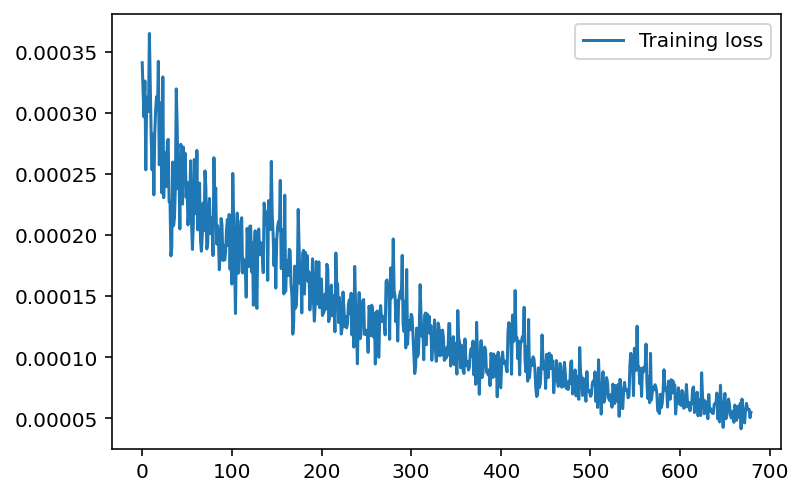

In [73]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(mv_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

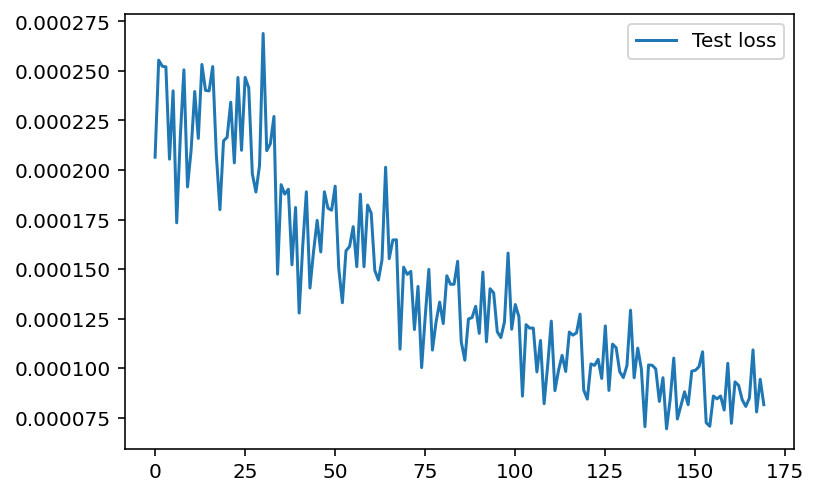

In [74]:
plt.plot(mv_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## (vi) Retrieve matrices

### a.Limited Partners matrix

In [75]:
lp_layer_model = keras.models.Model(inputs =[mv_net.model.input[0], mv_net.model.input[1], mv_net.model.input[2],mv_net.model.input[3],mv_net.model.input[4]],
                                    outputs =mv_net.model.get_layer("lp_combine_layer_flat").output)
lp_matrics = []

for item in lp.values:
    lpsector = np.zeros([1, 19])
    lpsector[0] = item.take(4)#make category the category column

    lp_combine_layer_flat_val = lp_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                  np.reshape(item.take(1), [1, 1]), 
                                                  np.reshape(item.take(2), [1, 1]), 
                                                  np.reshape(item.take(3), [1, 1]),  
                                                  lpsector])  
    lp_matrics.append(lp_combine_layer_flat_val)

pickle.dump((np.array(lp_matrics).reshape(-1, 200)), open('lp_matrics.p', 'wb'))
lp_matrics = pickle.load(open('lp_matrics.p', mode='rb'))

In [76]:
lp_m = pd.DataFrame(lp_matrics)
lp_m

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.269468,0.076245,0.175892,0.133561,-0.154122,0.009134,-0.272097,-0.224897,0.213993,0.005463,...,0.021036,-0.030064,0.059241,0.017566,-0.034585,-0.088456,0.158032,0.061281,0.272929,-0.165617
1,0.227582,0.028359,0.087354,0.096257,-0.115658,0.077510,-0.160259,-0.160074,0.137923,0.021381,...,-0.064539,-0.126596,0.066825,0.006796,0.037997,-0.025165,0.091109,0.005764,0.147964,-0.181228
2,0.232055,0.004433,0.090465,0.109328,-0.135834,0.097475,-0.200728,-0.174256,0.153369,-0.029378,...,-0.066194,-0.073561,0.035486,-0.001748,-0.053511,-0.008190,0.081939,0.031879,0.170858,-0.155557
3,0.282602,0.033423,0.183697,0.121597,-0.159861,0.022619,-0.267384,-0.193397,0.211400,0.035518,...,0.020477,-0.014652,0.044717,-0.014276,0.010972,-0.070460,0.153968,0.052773,0.243000,-0.144759
4,0.257904,0.070786,0.186724,0.155737,-0.151809,0.007362,-0.270593,-0.233507,0.205170,0.004478,...,-0.007261,-0.056854,0.035292,0.043970,-0.037427,-0.088020,0.151624,0.078696,0.276671,-0.184288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4553,0.305339,0.064429,0.168039,0.119462,-0.201658,-0.013008,-0.294998,-0.202301,0.244815,0.037426,...,0.027772,0.004516,0.041174,0.005529,-0.013213,-0.113980,0.182178,0.098109,0.257931,-0.163883
4554,0.281561,0.112658,0.171878,0.128337,-0.189735,-0.013133,-0.298257,-0.186818,0.239298,0.067421,...,0.034305,0.008490,0.041129,0.013694,-0.010555,-0.123583,0.160032,0.082841,0.271918,-0.138047
4555,0.268599,0.093248,0.177048,0.140363,-0.169074,-0.012024,-0.285574,-0.199506,0.236862,0.038689,...,0.041306,-0.002323,0.066010,0.007677,-0.040967,-0.101029,0.149850,0.070592,0.282732,-0.141138
4556,0.285350,0.086663,0.185673,0.147032,-0.199613,-0.018399,-0.294456,-0.177408,0.248240,0.056920,...,0.029106,-0.003772,0.043517,-0.003594,-0.015128,-0.100249,0.176774,0.091973,0.281338,-0.149240


In [77]:
#If needed:
# lp_m.to_csv('lp_m.csv')

### b.Fund Manager matrices

In [78]:
fm_layer_model = keras.models.Model(inputs =[mv_net.model.input[5], mv_net.model.input[6], mv_net.model.input[7],mv_net.model.input[8],mv_net.model.input[9],mv_net.model.input[10]],
                                    outputs =mv_net.model.get_layer("fm_combine_layer_flat").output)
fm_matrics = []

for item in fm.values:
    fmsector = np.zeros([1, 19])
    fmsector[0] = item.take(5)#make category the category column

    fm_combine_layer_flat_val = fm_layer_model([np.reshape(item.take(0), [1, 1]),
                                                  np.reshape(item.take(1), [1, 1]), 
                                                  np.reshape(item.take(2), [1, 1]), 
                                                  np.reshape(item.take(3), [1, 1]), 
                                                  np.reshape(item.take(4), [1, 1]),                                                    
                                                  fmsector])  
    fm_matrics.append(fm_combine_layer_flat_val)

pickle.dump((np.array(fm_matrics).reshape(-1, 200)), open('fm_matrics.p', 'wb'))
fm_matrics = pickle.load(open('fm_matrics.p', mode='rb'))

In [79]:
fm_m = pd.DataFrame(fm_matrics)
fm_m

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.084042,-0.040204,0.120000,0.009877,0.007092,0.085897,0.090959,-0.011949,0.029205,0.197009,...,-0.134616,-0.145519,0.013975,0.201327,0.004178,-0.035342,-0.002113,-0.146096,-0.021477,-0.000294
1,0.054172,-0.023208,0.143386,0.014994,0.042284,0.055727,0.084284,-0.035065,0.045065,0.193909,...,-0.150668,-0.185118,0.001981,0.182843,0.003337,0.005630,0.000965,-0.158520,-0.045276,0.012603
2,0.071647,-0.034249,0.126607,0.017611,0.021884,0.083644,0.092310,-0.015191,0.033562,0.197027,...,-0.131352,-0.161155,0.011329,0.202471,0.001946,-0.041614,-0.010817,-0.147644,-0.018646,0.008660
3,0.035221,-0.020356,0.124130,0.023412,0.059659,0.083269,0.090973,-0.009285,0.043433,0.173370,...,-0.128680,-0.195016,0.025823,0.165535,-0.008950,-0.040723,0.003445,-0.156125,-0.043982,0.031008
4,0.057676,-0.041524,0.117248,0.016745,0.035684,0.088642,0.085596,-0.012428,0.022272,0.192017,...,-0.107932,-0.161812,0.010272,0.189576,-0.007841,-0.065066,-0.001219,-0.135771,-0.022679,0.002964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4746,0.078071,-0.012210,0.141149,0.015356,0.008297,0.079053,0.086680,-0.003230,0.024639,0.190281,...,-0.151238,-0.147820,0.001893,0.202874,-0.003572,-0.059531,-0.023751,-0.130463,-0.014833,0.003930
4747,0.075275,-0.028586,0.128270,0.032093,0.025903,0.092748,0.094705,-0.003213,0.023692,0.199371,...,-0.147054,-0.154338,0.003486,0.207774,-0.007235,-0.028825,-0.011815,-0.146152,-0.026811,0.020612
4748,0.075554,-0.025421,0.132612,0.028762,0.011484,0.074664,0.083319,-0.036662,0.023393,0.197241,...,-0.151056,-0.152251,-0.002864,0.209576,0.003919,-0.024832,-0.029670,-0.144978,-0.016700,0.005319
4749,0.080648,-0.010249,0.115591,0.035188,0.010055,0.070998,0.093140,-0.019599,0.032880,0.220589,...,-0.165784,-0.137861,-0.003296,0.196329,0.004500,-0.021932,-0.015249,-0.150750,-0.005101,0.007441


In [80]:
# If needed
# fm_m.to_csv('fm_m.csv')

# V. Recommendation Function

## (i)Recommend with randomization

### A.Recommend limited partners to fund managers

#### a. Fund managers list

In [83]:
fm_list = fm_read[['fund_manager_id','fund_manager']]
fm_list.head()

,fund_manager_id,fund_manager
0,1,ACI Capital
1,2,Eurazeo
2,3,American Beacon
3,4,Capital Dynamics
4,5,Caisse de d?ot et placement du Qu?ec


#### b. Recommender for single recommendation

In [84]:
def recommend_lp(fm_id_input, top_k = 10):
  fm_index =fm.copy()
  fm_index.insert(0, 'ind', range(0, 4751))
  # print(fm_index[fm_index.fund_manager_id==fm_id_input].ind.values)
  fm_id_val = fm_index[fm_index.fund_manager_id==fm_id_input].ind.values[0]
  probs_embeddings = (fm_matrics[fm_id_val-1]).reshape([1, 200])

  probs_similarity = tf.matmul(probs_embeddings, tf.transpose(lp_matrics))
  sim = (probs_similarity.numpy())

  p = np.squeeze(sim)
  p[np.argsort(p)[:-10]] = 0
  p = p / np.sum(p)
  results = set()
  while len(results) != 10:
      c = np.random.choice(len(lp), 1, p=p)[0]
      results.add(c)
    
  df = pd.DataFrame()
  for val in (results):
      temp  = lp_all_orig[val].tolist()
      temp.append(val)
      df = df.append(pd.Series(temp),ignore_index=True)
  df['fund_manager_id'] = fm.fund_manager_id.iloc[fm_id_val]
  df['lp_id'] = df[0].astype(int)
  output = pd.merge(df, fm_read[['fund_manager_id','fund_manager']],on='fund_manager_id',how='left')
  output = pd.merge(output,lp_read,on='lp_id',how='inner')
  output = output[output.lp_if_na ==1]
  output.drop(columns=[0,1,2,3,4,5,'lp_id_orig','type_num','lp_if_na','asset_amount_bucket'],inplace=True)

  output1 =output.iloc[:, [0,2,1,3,4,5,6,7]]
  output1.rename(columns={"lp_name_x": "lp_name", "sector": "lp_sector","asset_amount":"asset_amount_million"},inplace=True)
 
  return output1

In [85]:
#all the emerging fund managers that have been trained by recommendation model
# input corresponding fund_manager_id into recommend_lp function for recommendations
fm_index =fm.copy()
fm_index.insert(0, 'ind', range(0, 4751))

check = pd.merge(fm_index,fm_match,on='fund_manager_id',how='inner')
emerging_funds_trained = check[['fund_manager_id','fund_manager']]
emerging_funds_trained

,fund_manager_id,fund_manager
0,49,Bank Gutmann
1,87,DuPont Capital Management
2,98,Darwin Ventures
3,100,Hall Capital Partners
4,294,Inventure
...,...,...
215,7162,UpWest
216,7233,Wakestream Ventures
217,7234,Walden Venture Capital
218,7277,Windhorse Group


#### c.Function application

In [86]:
#test with fund manager Inventure, id 294
#Return only limited partners inside of NA
recommend_lp(7292)

,fund_manager_id,fund_manager,lp_id,lp_name,type,asset_amount_million,hq_region,lp_sector
0,7292,Women's World Banking,4386,Alphabet,Corporate,169198.00,United States,"Financial Services,TMT"
1,7292,Women's World Banking,2055,Missouri Local Government Employees' Retiremen...,Public Pension Fund,10250.00,United States,"Biotech / Life Science,Clean Tech / Renewable,..."
2,7292,Women's World Banking,4369,Transamerica Life Insurance Company,Insurance Company,65208.35,United States,Unknown
3,7292,Women's World Banking,4308,Charles K. Blandin Foundation,Foundation / Endowment,43.17,United States,"Industrials,Consumer Goods"
5,7292,Women's World Banking,3542,San Francisco Conservatory of Music,Foundation / Endowment,42.00,United States,Unknown
6,7292,Women's World Banking,2231,Kohlberg & Company,Investment Firm,7800.00,United States,Unknown
7,7292,Women's World Banking,1756,Arkansas Community Foundation,Foundation / Endowment,507.83,United States,"Diversified,Natural Resources"
8,7292,Women's World Banking,3901,Coppermine Capital,Investment Firm,0.00,United States,"Business Services,Consumer Goods,Diversified,F..."
9,7292,Women's World Banking,4479,lshiyama Foundation,Foundation / Endowment,86.87,United States,Unknown


### B.Recommend fund managers to limited partners

#### a. Limited partner name list

In [87]:
lp_list = lp_read[['lp_id','lp_name_x']]
lp_list.head()

,lp_id,lp_name_x
0,1,Abell Foundation
1,2,ABN AMRO
2,3,Stichting Pensioenfonds ABP
3,4,AEGON USA
4,5,Aetna


#### b. Recommender function for single recommendation

In [88]:
#top_k could be modified according to need
# for a general matching (not for only emerging funds): set to 10

def recommend_fm(lp_id_input, top_k = 100):
    lp_index =lp.copy()
    lp_index.insert(0, 'ind', range(0, 4558))
   
    lp_id_val = lp_index[lp_index.lp_id==lp_id_input].ind.values[0]
    probs_embeddings = (lp_matrics[lp_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(fm_matrics))
    sim = (probs_similarity.numpy())

    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != top_k:
        c = np.random.choice(len(fm), 1, p=p)[0]
        results.add(c)
    
    df = pd.DataFrame()
    for val in (results):
        temp  = fm_all_orig[val].tolist()
        temp.append(val)
        df = df.append(pd.Series(temp),ignore_index=True)
    df['lp_id'] = lp.lp_id.iloc[lp_id_val]
    df['fund_manager_id'] = df[0].astype(int)

    output = pd.merge(df,fm_match,on='fund_manager_id',how='inner')
    output1 = pd.merge(output, lp_read[['lp_id','lp_name_x']])
    output1.drop(columns = [0,1,2,3,4,5,6,'fund_manager_id_orig'],inplace=True)

    output1 =output1.iloc[:, [0,8,1,2,3,4,5,6,7]]
    output1.rename(columns={"lp_name_x": "lp_name", "sectors": "fund_manager_sector","fund_size":"fund_size_million"},inplace=True)
    output1

    return output1

#### c. Function application

In [ ]:
#test with limited partner Oregon State Treasury, id 245
recommend_fm(245)

,lp_id,lp_name,fund_manager_id,fund_manager,strategies,fund_size_million,region_if_na,fund_num,fund_manager_sector
0,245,Oregon State Treasury,4610,Deepwork Capital,Venture Capital / Growth Equity,50.0,1,3,Healthcare
1,245,Oregon State Treasury,4642,Entourage Effect Capital,Buyout / Corporate Private Equity,100.0,1,3,Healthcare


## (ii) All dot products
### This method returns prediction for each combination between lps and fms. It may provide new prespective to analysis but very slow to process.

### Codes

In [ ]:
lp_test = lp.copy()
lp_test = lp_test.reset_index(drop=True)
lp_test['lp_index'] = lp_test.index
lp_use = lp_test[['lp_id','lp_index']]
lp_cross = lp_test[['lp_id']]

In [ ]:
fm_test = fm.copy()
fm_test = fm_test.reset_index(drop=True)
fm_test['fm_index'] = fm_test.index
fm_use = fm_test[['fund_manager_id','fm_index']]
fm_cross = fm_test[['fund_manager_id']]

In [ ]:
newdf = lp_cross.merge(fm_cross,how='cross')

In [ ]:
newdf1 = newdf.merge(lp_use,on='lp_id',how='left')
newdf2 = newdf1.merge(fm_use, on='fund_manager_id',how='left')
newdf2

,lp_id,fund_manager_id,lp_index,fm_index
0,1,1,0,0
1,1,2,0,1
2,1,3,0,2
3,1,4,0,3
4,1,5,0,4
...,...,...,...,...
21655053,5714,7281,4557,4746
21655054,5714,7289,4557,4747
21655055,5714,7292,4557,4748
21655056,5714,7296,4557,4749


In [ ]:
def get_result():
  temp3= []
  for i in range(len(newdf2)):
    lp_index = newdf2['lp_index'][i]
    fm_index = newdf2['fm_index'][i]
    lp_vec = (lp_matrics[lp_index])
    fm_vec = (fm_matrics[fm_index])
    product = np.dot(lp_vec, fm_vec)
    temp3.append(product)
  return temp3

In [ ]:
ultimate = get_result()
newdf2['results'] = ultimate
newdf2

,lp_id,fund_manager_id,lp_index,fm_index,results
0,1,1,0,0,0.969666
1,1,2,0,1,0.963328
2,1,3,0,2,0.965779
3,1,4,0,3,0.960165
4,1,5,0,4,0.954087
...,...,...,...,...,...
21655053,5714,7281,4557,4746,0.972496
21655054,5714,7289,4557,4747,0.986658
21655055,5714,7292,4557,4748,0.999264
21655056,5714,7296,4557,4749,0.995804


In [ ]:
#use a qcut to equally divide rating results into 8 levels
newdf2['how_recommend'] = pd.qcut(newdf2['results'], q=8,labels=False)

In [ ]:
newdf2

,lp_id,fund_manager_id,lp_index,fm_index,results,how_recommend
0,1,1,0,0,0.969666,1
1,1,2,0,1,0.963328,0
2,1,3,0,2,0.965779,0
3,1,4,0,3,0.960165,0
4,1,5,0,4,0.954087,0
...,...,...,...,...,...,...
21655053,5714,7281,4557,4746,0.972496,1
21655054,5714,7289,4557,4747,0.986658,2
21655055,5714,7292,4557,4748,0.999264,4
21655056,5714,7296,4557,4749,0.995804,3


### Downloaded CSV file

In [81]:
#Import limited partner features
link = 'https://drive.google.com/file/d/1HvHlN5X4bXT34ELVlj13HinPyRbaRSrP/view?usp=sharing'


# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('2000wRecommend.csv') 
 
all_r_read = pd.read_csv('2000wRecommend.csv',encoding = "ISO-8859-1")

In [89]:
#recommendation level from low to high: 0 to 7, 0 means no interest, 7 means very interested in 
all_r_read.head(10)

,Unnamed: 0,lp_id,fund_manager_id,how_recommend
0,0,1,1,1
1,1,1,2,0
2,2,1,3,0
3,3,1,4,0
4,4,1,5,0
5,5,1,6,0
6,6,1,7,0
7,7,1,8,0
8,8,1,9,0
9,9,1,10,0
